In [1]:
! pip install jiwer

In [2]:
import pandas as pd
import torch

from datasets import load_metric
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import TrOCRProcessor,Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

/home/stacy/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-07-27 17:23:04.548975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 17:23:04.675735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 17:23:04.713251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 17:23:04.922523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following

##### Dataset class

In [3]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

##### Dataset Preparation

In [4]:
df = pd.read_csv('./ocr_dataset/labels.csv', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df.head()

,file_name,text
0,AT0913IA.jpg,AT0913IA
1,CA6888BH.jpg,CA6888BH
2,KI4108AB.jpg,KI4108AB
3,BC1615MC.jpg,BC1615MC
4,AA3002YA.jpg,AA3002YA


In [5]:
train_df, test_df = train_test_split(df, test_size=0.3)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
train_dataset = IAMDataset(root_dir='./ocr_dataset/img/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='./ocr_dataset/img/',
                           df=test_df,
                           processor=processor)

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 869
Number of validation examples: 373


In [8]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


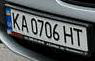

In [9]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [10]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

KA0706HT


##### Model Finetuning

In [11]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [14]:
cer_metric = load_metric("cer", trust_remote_code=True)

/tmp/ipykernel_19119/2056700229.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer", trust_remote_code=True)


In [15]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [16]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=500,
)

/home/stacy/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/home/stacy/anaconda3/lib/python3.11/site-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


  0%|          | 0/1305 [00:00<?, ?it/s]

{'loss': 8.1693, 'grad_norm': 101.0296630859375, 'learning_rate': 4.9923371647509584e-05, 'epoch': 0.0}
{'loss': 3.0079, 'grad_norm': 174.7723846435547, 'learning_rate': 4.984674329501916e-05, 'epoch': 0.01}
{'loss': 5.5139, 'grad_norm': 109.33425903320312, 'learning_rate': 4.977011494252874e-05, 'epoch': 0.01}
{'loss': 2.855, 'grad_norm': 61.90847396850586, 'learning_rate': 4.9693486590038316e-05, 'epoch': 0.02}
{'loss': 2.5367, 'grad_norm': 82.93531799316406, 'learning_rate': 4.96168582375479e-05, 'epoch': 0.02}
{'loss': 1.896, 'grad_norm': 100.90845489501953, 'learning_rate': 4.954022988505747e-05, 'epoch': 0.03}
{'loss': 1.4978, 'grad_norm': 41.58099365234375, 'learning_rate': 4.946360153256705e-05, 'epoch': 0.03}
{'loss': 2.4571, 'grad_norm': 94.52740478515625, 'learning_rate': 4.938697318007663e-05, 'epoch': 0.04}
{'loss': 1.3744, 'grad_norm': 89.43819427490234, 'learning_rate': 4.931034482758621e-05, 'epoch': 0.04}
{'loss': 1.432, 'grad_norm': 34.1403694152832, 'learning_rate': 

/home/stacy/anaconda3/lib/python3.11/site-packages/transformers/generation/utils.py:1376: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


  0%|          | 0/187 [00:00<?, ?it/s]

{'eval_loss': 0.4718005359172821, 'eval_cer': 0.06099195710455764, 'eval_runtime': 5341.1868, 'eval_samples_per_second': 0.07, 'eval_steps_per_second': 0.035, 'epoch': 1.15}
{'loss': 0.9668, 'grad_norm': 36.08891677856445, 'learning_rate': 3.0766283524904214e-05, 'epoch': 1.15}
{'loss': 0.3232, 'grad_norm': 25.068803787231445, 'learning_rate': 3.0689655172413796e-05, 'epoch': 1.16}
{'loss': 0.9145, 'grad_norm': 228.50827026367188, 'learning_rate': 3.061302681992337e-05, 'epoch': 1.16}
{'loss': 1.1571, 'grad_norm': 1.967034101486206, 'learning_rate': 3.053639846743295e-05, 'epoch': 1.17}
{'loss': 0.1474, 'grad_norm': 11.758615493774414, 'learning_rate': 3.045977011494253e-05, 'epoch': 1.17}
{'loss': 0.6233, 'grad_norm': 48.88976287841797, 'learning_rate': 3.0383141762452112e-05, 'epoch': 1.18}
{'loss': 0.0039, 'grad_norm': 0.38103389739990234, 'learning_rate': 3.030651340996169e-05, 'epoch': 1.18}
{'loss': 0.0681, 'grad_norm': 5.229486465454102, 'learning_rate': 3.0229885057471262e-05, 

  0%|          | 0/187 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 0.14444275200366974, 'eval_cer': 0.02379356568364611, 'eval_runtime': 5314.7655, 'eval_samples_per_second': 0.07, 'eval_steps_per_second': 0.035, 'epoch': 2.3}
{'loss': 0.074, 'grad_norm': 10.758091926574707, 'learning_rate': 1.1609195402298852e-05, 'epoch': 2.3}
{'loss': 0.1902, 'grad_norm': 0.0923178493976593, 'learning_rate': 1.1532567049808429e-05, 'epoch': 2.31}
{'loss': 0.0063, 'grad_norm': 0.6164608001708984, 'learning_rate': 1.1455938697318007e-05, 'epoch': 2.31}
{'loss': 0.0173, 'grad_norm': 2.955955743789673, 'learning_rate': 1.1379310344827587e-05, 'epoch': 2.32}
{'loss': 0.008, 'grad_norm': 0.07959303259849548, 'learning_rate': 1.1302681992337164e-05, 'epoch': 2.32}
{'loss': 0.0251, 'grad_norm': 0.10282594710588455, 'learning_rate': 1.1226053639846744e-05, 'epoch': 2.33}
{'loss': 0.0086, 'grad_norm': 2.536823034286499, 'learning_rate': 1.1149425287356322e-05, 'epoch': 2.33}
{'loss': 0.0069, 'grad_norm': 2.3708229064941406, 'learning_rate': 1.10727969348659e-05

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'train_runtime': 48890.5283, 'train_samples_per_second': 0.053, 'train_steps_per_second': 0.027, 'train_loss': 0.5062505748377283, 'epoch': 3.0}


TrainOutput(global_step=1305, training_loss=0.5062505748377283, metrics={'train_runtime': 48890.5283, 'train_samples_per_second': 0.053, 'train_steps_per_second': 0.027, 'total_flos': 1.9507794929264886e+18, 'train_loss': 0.5062505748377283, 'epoch': 3.0})

In [20]:
model.save_pretrained('./results/trocr-finetuned')
processor.save_pretrained('./results/trocr-finetuned')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


[]